# <a>Projeto 3 - Classificação usando Scikit Learn e XGBoost</a>

*Let's Data - Jornada Cientista da Dados*

## <a> Motivação </a>

Muitos problemas da vida real na carreira de cientista de dados são modelados como classificação. Quando nossa variável dependente é discreta, temos uma classificação. As classes podem ser somente duas (variável dependente binária) ou problemas multiclasse.

 Escolher a melhor forma de tratar dados faltantes (missing data), realizar uma boa engenharia de features (feature engineering) e selecionar a melhor métrica para cada projeto são partes essenciais e que requerem uma certa "criatividade" de nossa parte.

## <a> Objeto de Estudo </a>

Um problema muito recorrente para muitas empresas é qual a melhor forma de reter seus clientes. Saber de antemão se um cliente vai cancelar os serviços é uma grande vantagem competitiva para qualquer empresa. A estratégia de marketing, CRM e as equipes de vendas podem se beneficiar muito se tiver informações de quais clientes tem mais chances de deixar de contratar os serviços de uma empresa.

Esse tipo de problema é chamado de previsão de churn (de churn rate, ou, % de clientes que deixam a empresa num determinado tempo). Para resolver esse tipo de problema precisamos ter uma base histórica com clientes que saíram e não saíram da empresa, bem como suas características.

Bancos, telefônicas, varejo, qualquer empresa que presta algum tipo de serviços e possui informações sobre seus clientes pode se beneficiar de modelos preditivos similares aos que irei construir.

Nesse projeto, vou ajudar a Let's Talk (empresa telefônica da holding Let's Data) a manter seus clientes. Farei isso criando modelos para classificar os clientes em "churn" ou "não churn", ou seja, se irão cancelar os serviços ou não.

A base utilizada pode ser obtida no [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn) e se trata de uma empresa telefônica fictícia com dados demográficos e de serviços contratados pelos  clientes com a informação se saiu ou não da empresa.

In [ ]:
#!pip install xgboost

In [ ]:
# importando as bibliotecas para leitura dos dados e criação de gráficos
import os
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# configruando pandas para mostrar todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# configurando pandas para não mostrar notação cientifica para números
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# Ler os dados da telefonica. Existe uma base de testes, mas ela não tem as respostas, então não serve muito para o nosso cargo
df_clientes = pd.read_csv("/content/train.csv")
df_clientes.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.00,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.00,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.00,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.00,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [ ]:
df_clientes.columns

Index(['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df_clientes['id'].is_unique

True

Entendendo as colunas:
- id: identificação do cliente
- gender: sexo do cliente
- SeniorCitizen: indicador se é um(a) idoso(a)
- Partner: indicador se tem um parceiro(a)
- Dependents: indicador se possui dependentes
- tenure: quantos meses o cliente está na empresa
- PhoneService: indicador se possui serviços de telefonia
- MultipleLines: indicador se possui múltiplas linhas telefônicas
- InternetService: indicador se possui serviços de internet
- OnlineSecurity: indicador se possui serviços de segurança online
- OnlineBackup: indicador se possui serviços de backup online
- DeviceProtection: indicador se possui serviços de proteção de equipamentos
- TechSupport: indicador se possui serviços de suporte técnico
- StreamingTV: indicador se possui serviços de streaming de tv
- StreamingMovies: indicador se possui serviços de streaming de filmes
- Contract: tipo de contrato
- PaperlessBilling: indicador se a cobrança é via papel ou não (cobrança eletrônica)
- PaymentMethod: indicador do tipo de pagamento
- MonthlyCharges: valor mensal dos serviços
- TotalCharges: valor total dos serviços desde o início do contrato
- Churn: indicador se saiu da empresa ou não

In [ ]:
# Vamos transformar id em indice do dataframe
df_clientes = df_clientes.set_index('id')
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
4030,Female,0,No,No,56.00,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
6479,Female,0,Yes,No,60.00,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
6861,Female,0,No,No,37.00,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
3266,Male,0,Yes,Yes,29.00,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [ ]:
# Avaliando a quantidade de linhas e colunas
df_clientes.shape

(5634, 20)

In [ ]:
# Avaliando os tipos
df_clientes.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,float64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [ ]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 4030 to 103
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5634 non-null   object 
 1   SeniorCitizen     5634 non-null   int64  
 2   Partner           5634 non-null   object 
 3   Dependents        5416 non-null   object 
 4   tenure            5173 non-null   float64
 5   PhoneService      5634 non-null   object 
 6   MultipleLines     5634 non-null   object 
 7   InternetService   5634 non-null   object 
 8   OnlineSecurity    5634 non-null   object 
 9   OnlineBackup      5634 non-null   object 
 10  DeviceProtection  5634 non-null   object 
 11  TechSupport       5634 non-null   object 
 12  StreamingTV       5634 non-null   object 
 13  StreamingMovies   5634 non-null   object 
 14  Contract          5634 non-null   object 
 15  PaperlessBilling  5634 non-null   object 
 16  PaymentMethod     5535 non-null   object 
 17

TotalCharges está como object, mas deveria ser float, vou fazer a conversão

In [ ]:
df_clientes['TotalCharges'].dtype

dtype('O')

In [ ]:
df_clientes['TotalCharges'].value_counts()

,count
TotalCharges,
20.2,8
,8
19.55,7
19.75,6
19.9,6
19.45,6
19.65,6
20.05,6
20.25,6


In [ ]:
# Vamos tirar os espaços primeiro. Usando expressão regular simples \s é qualquer
# Caractere de espaço,seja espaçosimples ou tabulação. \s+ pega uma ou mais sequências de espaços
df_clientes['TotalCharges'] = df_clientes['TotalCharges'].replace("\s+", "", regex=True)

In [ ]:
# Não funcionou porque existem valores que não conseguem ter conversão para float
df_clientes.loc[df_clientes['TotalCharges'] == '']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
6755,Male,0,No,Yes,0.00,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,0
5219,Male,0,Yes,Yes,0.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6671,Female,0,Yes,Yes,0.00,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0
937,Female,0,Yes,Yes,0.00,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
3827,Male,0,Yes,Yes,0.00,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
1083,Male,0,Yes,Yes,0.00,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
3332,Male,0,Yes,Yes,0.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
1341,Female,0,Yes,Yes,0.00,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0


In [ ]:
# Para converter podemos utilizar o to_numeric com coerção de erro
pd.to_numeric(df_clientes['TotalCharges'], errors='coerce')

,TotalCharges
id,
4030,2560.10
6731,332.65
6479,6640.70
6861,3545.35
3266,1974.80
6368,3442.80
5830,1848.80
4476,61.05
1508,1008.70


In [ ]:
# Pegando os indices das linhas que tem nulos para saber como o to_numeric converge
indices_total_charges_nulo = df_clientes.loc[df_clientes['TotalCharges'] == ''].index
indices_total_charges_nulo

Index([6755, 5219, 6671, 937, 3827, 1083, 3332, 1341], dtype='int64', name='id')

In [ ]:
# Filtrando pelos indices pra ver como o to_numeric realiza a coreção de erros
pd.to_numeric(df_clientes['TotalCharges'], errors='coerce')[indices_total_charges_nulo]

,TotalCharges
id,
6755,NaN
5219,NaN
6671,NaN
937,NaN
3827,NaN
1083,NaN
3332,NaN
1341,NaN


In [ ]:
# ele fora para converter tudo que é numérico para NaN
df_clientes['TotalCharges'] = pd.to_numeric(df_clientes['TotalCharges'], errors='coerce')

In [ ]:
df_clientes.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,float64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


## <a> Começando com estatística descritiva </a>

Conhecer bem as medidas estatísticas, de tendência central, dispersão, separatrizes, distribuições, é essencial para conhecer melhor os dados em que estou trabalhando. Qual a distribuição de tenure? Da cobrança mensal? Da cobrança total? A base está desbalanceada?

In [ ]:
df_clientes.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,5634.00,5173.00,5634.00,5626.00,5634.00
mean,0.16,32.33,64.63,2273.51,0.27
std,0.37,24.46,30.02,2258.38,0.44
min,0.00,0.00,18.25,18.80,0.00
25%,0.00,9.00,35.46,401.59,0.00
50%,0.00,29.00,70.25,1396.12,0.00
75%,0.00,55.00,89.80,3764.29,1.00
max,1.00,72.00,118.75,8684.80,1.00


SeniorCitizen e Churn são discretas, mas por serem float acabou entrando: irei ignorar.

Posso perceber que tenure tem máximo de 72 meses (6 anos). Posso inferir que os dados foram coletados com essa janela.

<Axes: xlabel='tenure', ylabel='Count'>

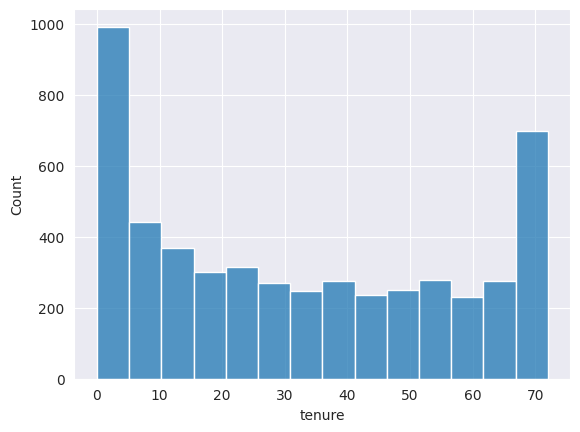

In [ ]:
# Analisando a distribuição de tenure(meses na empresa)
sns.set_style("darkgrid")
plt.tight_layout()

sns.histplot(data=df_clientes, x='tenure' )

In [ ]:
# Teremos muitos valores próximos a zero, vamos avaliar?

len(df_clientes.loc[df_clientes['tenure'] <= 5])

992

In [ ]:
100 * len(df_clientes.loc[df_clientes['tenure'] <= 5]) / df_clientes.shape[0]

17.607383741569045

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

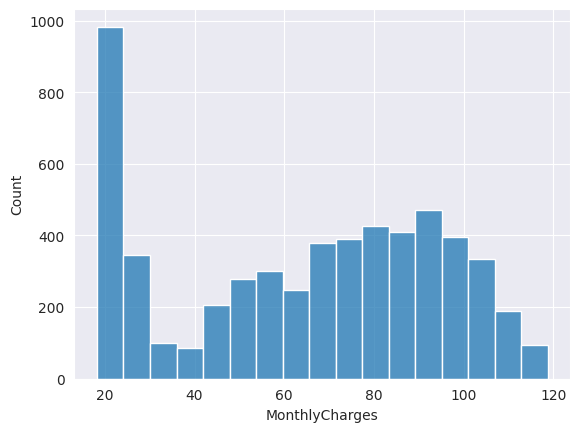

In [ ]:
# Analisando a distribuição da cobrança mensal
sns.set_style("darkgrid")
plt.tight_layout()

sns.histplot(data=df_clientes, x='MonthlyCharges')

<Axes: xlabel='TotalCharges', ylabel='Count'>

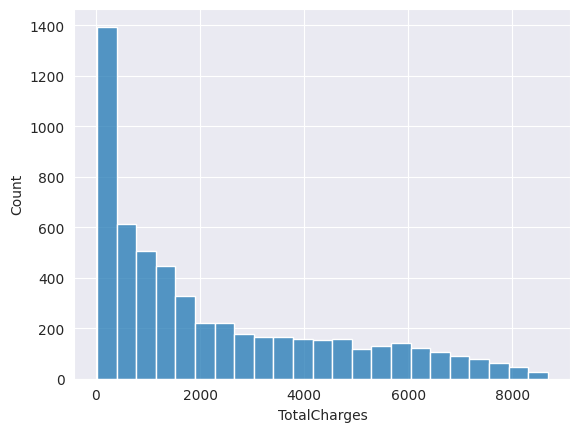

In [ ]:
# Analisando a distribuição da cobrança total
sns.set_style("darkgrid")
plt.tight_layout()

sns.histplot(data=df_clientes, x='TotalCharges')

<Axes: xlabel='Churn', ylabel='count'>

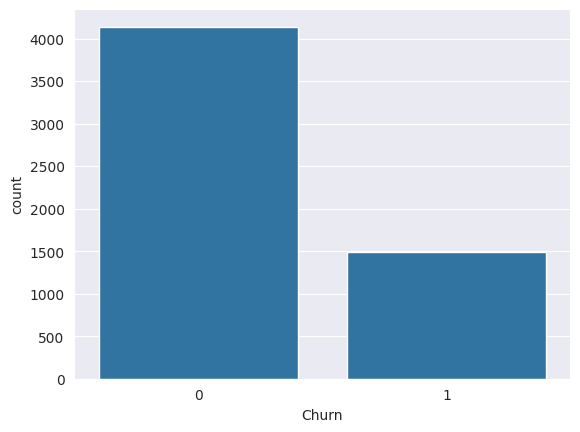

In [ ]:
# Analisando  a variável target: churn (cancelou os serviços da empresa ou não)
sns.countplot(data=df_clientes, x ='Churn')

Tem uma base bastante desbalanceada. Tem que tomar cuidado com a métrica a ser utilizada. Vou avaliar o desbalanceamento.

In [ ]:
len(df_clientes.loc[df_clientes['Churn'] == 0]), len(df_clientes.loc[df_clientes['Churn'] == 1])

(4139, 1495)

In [ ]:
# Se o modelo chutar como "Não saiu da empresa"
100 * len(df_clientes.loc[df_clientes['Churn'] == 0]) / df_clientes.shape[0]

73.46467873624424

## <a> Relação entre as features e a variável target </a>

Uma análise interessante é avaliar relações entre as variáveis preditoras com a target. Vou analisar as dispersões das variáveis preditoras com o churn

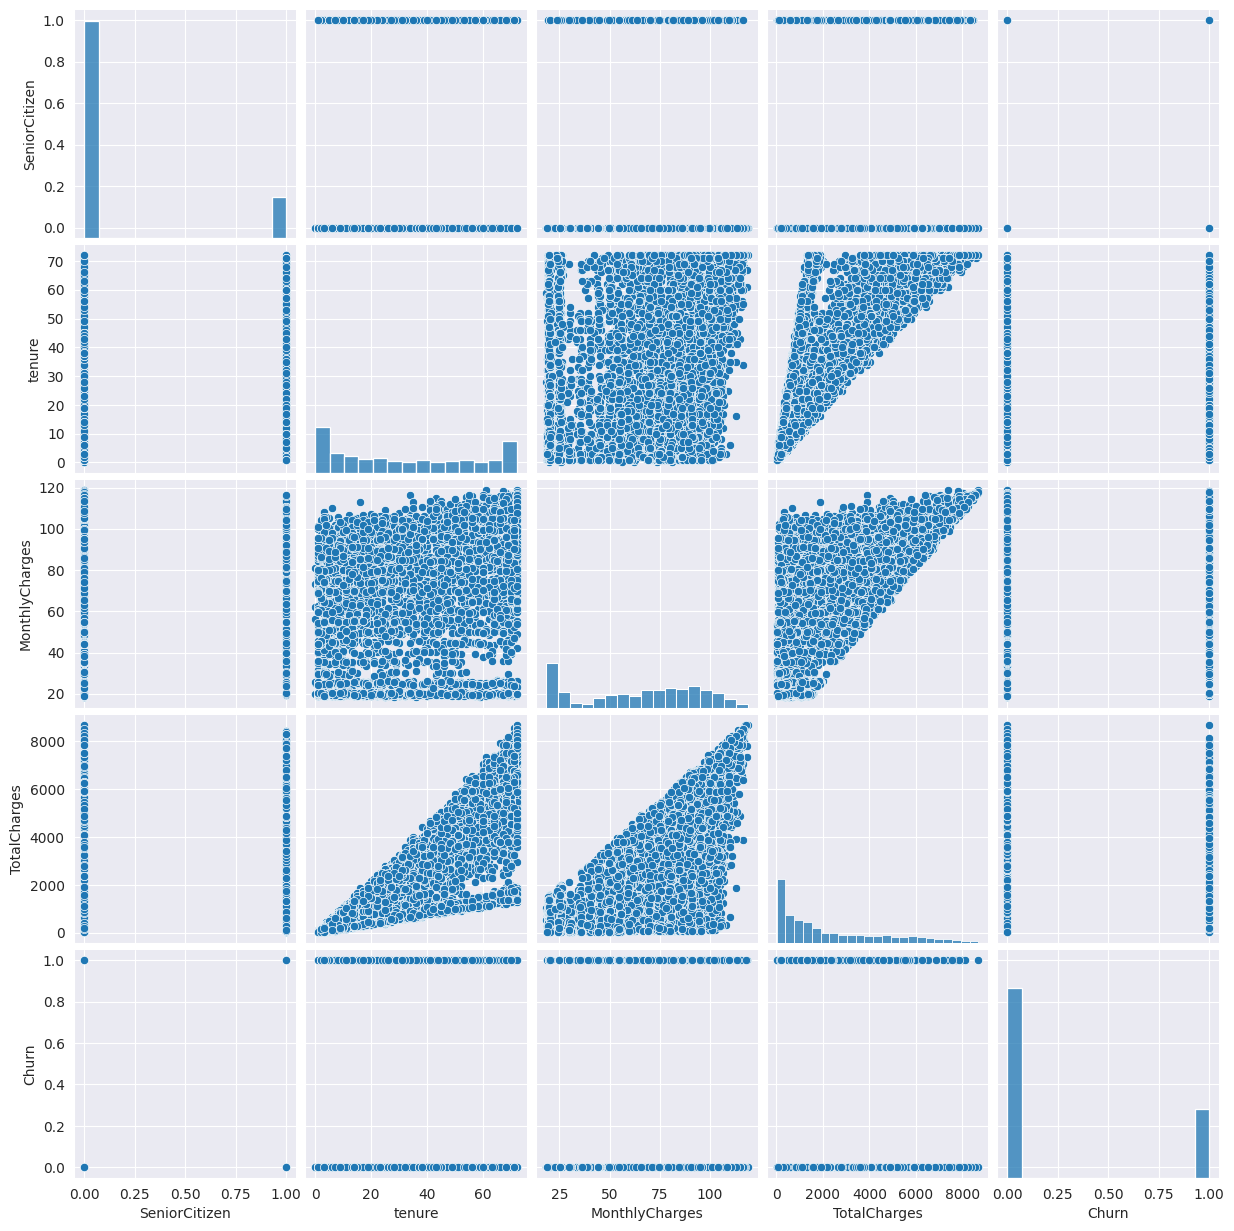

In [ ]:
# O  pairplot faz gráficos de dispersão para os pares de variáveis
# Na diagonal principal ele mostra o histograma
sns.pairplot(data=df_clientes)

Fica evidente uma correlação positiva entre tenure e cobranças totais (o que é bem óbvio). Além disso, nada que chame muito a atenção com relação à variável target. Como ela é categórica, se tivéssemos um gráfico que nem o abaixo, poderíamos inferir uma correlação forte

## <a> Codificação de Variáveis Categóricas </a>

Lembrando que os modelos de machine learning não sabem o que são categorias em sua maioria, devemos, portanto, codificar as variáveis de sexo, parceiro(a), dependentes, tipo de cobrança e todos os tipos de serviço.

In [ ]:
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
4030,Female,0,No,No,56.00,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.10,0
6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
6479,Female,0,Yes,No,60.00,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.70,0
6861,Female,0,No,No,37.00,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
3266,Male,0,Yes,Yes,29.00,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.80,1


In [ ]:
colunas_categoricas = [coluna for coluna in df_clientes.columns if coluna not in df_clientes._get_numeric_data()]
colunas_categoricas

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
for coluna_categorica in colunas_categoricas:
    display(df_clientes[coluna_categorica].value_counts())

,count
gender,
Male,2849
Female,2785


,count
Partner,
No,2902
Yes,2732


,count
Dependents,
No,3793
Yes,1623


,count
PhoneService,
Yes,5082
No,552


,count
MultipleLines,
No,2692
Yes,2390
No phone service,552


,count
InternetService,
Fiber optic,2451
DSL,1959
No,1224


,count
OnlineSecurity,
No,2763
Yes,1647
No internet service,1224


,count
OnlineBackup,
No,2488
Yes,1922
No internet service,1224


,count
DeviceProtection,
No,2480
Yes,1930
No internet service,1224


,count
TechSupport,
No,2793
Yes,1617
No internet service,1224


,count
StreamingTV,
No,2240
Yes,2170
No internet service,1224


,count
StreamingMovies,
No,2218
Yes,2192
No internet service,1224


,count
Contract,
Month-to-month,3084
Two year,1358
One year,1192


,count
PaperlessBilling,
Yes,3312
No,2322


,count
PaymentMethod,
Electronic check,1887
Mailed check,1272
Bank transfer (automatic),1212
Credit card (automatic),1164


In [ ]:
# Mapear gender, partner, dependents, phone service e paperless biling
df_clientes['gender'] = df_clientes['gender'].map({'Female': 1, 'Male': 0})

colunas_binarias = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for coluna_binaria in colunas_binarias:
    df_clientes[coluna_binaria]  = df_clientes[coluna_binaria].map({'Yes': 1, 'No': 0 })

In [ ]:
df_clientes.loc[:, colunas_binarias + ['gender']].isnull().sum()

,0
Partner,0
Dependents,218
PhoneService,0
PaperlessBilling,0
gender,0


In [ ]:
# Atualizando as colunas que ainda são categóricas
colunas_categoricas = [coluna for coluna in df_clientes.columns if coluna not in df_clientes._get_numeric_data()]
colunas_categoricas

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [ ]:
for coluna_categorica in colunas_categoricas:
    display(df_clientes[coluna_categorica].value_counts())

,count
MultipleLines,
No,2692
Yes,2390
No phone service,552


,count
InternetService,
Fiber optic,2451
DSL,1959
No,1224


,count
OnlineSecurity,
No,2763
Yes,1647
No internet service,1224


,count
OnlineBackup,
No,2488
Yes,1922
No internet service,1224


,count
DeviceProtection,
No,2480
Yes,1930
No internet service,1224


,count
TechSupport,
No,2793
Yes,1617
No internet service,1224


,count
StreamingTV,
No,2240
Yes,2170
No internet service,1224


,count
StreamingMovies,
No,2218
Yes,2192
No internet service,1224


,count
Contract,
Month-to-month,3084
Two year,1358
One year,1192


,count
PaymentMethod,
Electronic check,1887
Mailed check,1272
Bank transfer (automatic),1212
Credit card (automatic),1164


Posso inferir que Contract é ordinal, pois possui claramente uma diferença entre os tipos de contrato mensais, anuais e bianuais. Outras que podemos (forçando um pouquinho a barra) são InternetService e PaymentMethod. A 1a porque tendo em vista que fibra ótica normalmente é mais rápida que ADSL (e provavelmente mais cara também). A 2a porque posso avaliar a facilidade de cobrança pelo correio ser mais difícil/lenta que as mais automáticas e eletrônicas

In [ ]:
df_clientes['Contract'] = df_clientes['Contract'].map({
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
})


df_clientes['InternetService'] = df_clientes['InternetService'].map({
    'No': 0,
    'DSL': 1,
    'Fiber optic': 2
})

df_clientes['PaymentMethod'] = df_clientes['PaymentMethod'].map({
    'Mailed check': 0,
    'Electronic check': 1,
    'Bank transfer (automatic)': 2,
    'Credit card (automatic)': 3
})

df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
4030,1,0,0,0.00,56.00,0,No phone service,1,Yes,Yes,Yes,Yes,No,No,2,0,NaN,45.05,2560.10,0
6731,0,0,1,1.00,NaN,1,No,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,1,0,0.00,19.65,332.65,0
6479,1,0,1,0.00,60.00,1,Yes,2,No,Yes,Yes,Yes,Yes,Yes,2,1,3.00,110.80,6640.70,0
6861,1,0,0,0.00,37.00,1,Yes,2,No,Yes,Yes,No,Yes,Yes,0,1,2.00,101.90,3545.35,1
3266,0,0,1,1.00,29.00,1,No,2,No,No,No,No,No,No,0,1,1.00,70.75,1974.80,1


In [ ]:
df_clientes.dtypes

,0
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,float64
tenure,float64
PhoneService,int64
MultipleLines,object
InternetService,int64
OnlineSecurity,object
OnlineBackup,object


In [ ]:
# Atualizando as colunas que ainda são categoricas
colunas_categoricas = [coluna for coluna in df_clientes.columns if coluna not in df_clientes._get_numeric_data()]
colunas_categoricas

['MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
ohe = OneHotEncoder(drop='first')
df_ohe_transformadas = ohe.fit_transform(df_clientes[colunas_categoricas])
ohe.categories_

[array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object)]

In [ ]:
ohe.get_feature_names_out()

array(['MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype=object)

In [ ]:
df_ohe_transformadas

<5634x14 sparse matrix of type '<class 'numpy.float64'>'
	with 21764 stored elements in Compressed Sparse Row format>

In [ ]:
# Transformando o array numpy em colunas.
df_ohe_transformadas = pd.DataFrame.sparse.from_spmatrix(data=df_ohe_transformadas,
                                                       columns=ohe.get_feature_names_out(),
                                                       index = df_clientes.index)
df_ohe_transformadas.head()

,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,
4030,1.00,0,0,1.00,0,1.00,0,1.00,0,1.00,0,0,0,0
6731,0,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0
6479,0,1.00,0,0,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00
6861,0,1.00,0,0,0,1.00,0,1.00,0,0,0,1.00,0,1.00
3266,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_ohe_transformadas.shape

(5634, 14)

In [ ]:
# Utilizando o concat para realizar um "JOIN" entre os dataframes original e com
# axis=0 ele apensaria as linhas, axis=1 ele junta as colunas
df_clientes = pd.concat([df_clientes, df_ohe_transformadas], axis=1)
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4030,1,0,0,0.00,56.00,0,No phone service,1,Yes,Yes,Yes,Yes,No,No,2,0,NaN,45.05,2560.10,0,1.00,0,0,1.00,0,1.00,0,1.00,0,1.00,0,0,0,0
6731,0,0,1,1.00,NaN,1,No,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,1,0,0.00,19.65,332.65,0,0,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0
6479,1,0,1,0.00,60.00,1,Yes,2,No,Yes,Yes,Yes,Yes,Yes,2,1,3.00,110.80,6640.70,0,0,1.00,0,0,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00
6861,1,0,0,0.00,37.00,1,Yes,2,No,Yes,Yes,No,Yes,Yes,0,1,2.00,101.90,3545.35,1,0,1.00,0,0,0,1.00,0,1.00,0,0,0,1.00,0,1.00
3266,0,0,1,1.00,29.00,1,No,2,No,No,No,No,No,No,0,1,1.00,70.75,1974.80,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Remover as colunas originais
df_clientes = df_clientes.drop(colunas_categoricas, axis=1)
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
4030,1,0,0,0.00,56.00,0,1,2,0,NaN,45.05,2560.10,0,1.00,0,0,1.00,0,1.00,0,1.00,0,1.00,0,0,0,0
6731,0,0,1,1.00,NaN,1,0,1,0,0.00,19.65,332.65,0,0,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0
6479,1,0,1,0.00,60.00,1,2,2,1,3.00,110.80,6640.70,0,0,1.00,0,0,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00
6861,1,0,0,0.00,37.00,1,2,0,1,2.00,101.90,3545.35,1,0,1.00,0,0,0,1.00,0,1.00,0,0,0,1.00,0,1.00
3266,0,0,1,1.00,29.00,1,2,0,1,1.00,70.75,1974.80,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_clientes.dtypes

,0
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,float64
tenure,float64
PhoneService,int64
InternetService,int64
Contract,int64
PaperlessBilling,int64
PaymentMethod,float64


variáveis todas numéricas!!

## <a> Determinando quem são variáveis preditoras e variável target </a>

Variáveis preditoras: X; variável target: y.

In [ ]:
df_clientes.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype='object')

In [ ]:
X = df_clientes.drop('Churn', axis=1) # tirando a variável dependente
y = df_clientes['Churn'] # extraindo a variável dependente

In [ ]:
# Variáveis preditoras (ou independentes ou, features)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,
4030,1,0,0,0.00,56.00,0,1,2,0,NaN,45.05,2560.10,1.00,0,0,1.00,0,1.00,0,1.00,0,1.00,0,0,0,0
6731,0,0,1,1.00,NaN,1,0,1,0,0.00,19.65,332.65,0,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0
6479,1,0,1,0.00,60.00,1,2,2,1,3.00,110.80,6640.70,0,1.00,0,0,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00
6861,1,0,0,0.00,37.00,1,2,0,1,2.00,101.90,3545.35,0,1.00,0,0,0,1.00,0,1.00,0,0,0,1.00,0,1.00
3266,0,0,1,1.00,29.00,1,2,0,1,1.00,70.75,1974.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Variável dependente, ou target, ou label
y.head()

,Churn
id,
4030,0
6731,0
6479,0
6861,1
3266,1


## <a> Separação de bases </a>

Vou separar logo as bases, isso evita tratamento de missing data (valores faltantes), por exemplo, e tais transformações deve ser realizadas DEPOIS do split (separação).

In [ ]:
# Seprar a base em treino e teste
# Para fazer um cross validation com a base de treino
from sklearn.model_selection import train_test_split

In [ ]:
# Devolve uma tupla com 4 elementos : X de treino, X de teste, y de treino e y de teste
X_train, X_test, y_train, y_test = train_test_split(X, # preditoras
                                                    y, # target
                                                    test_size=.2,
                                                    random_state=42)

# Verificar com quantas linhas de treino e teste ficaram
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4507, 26), (1127, 26), (4507,), (1127,))

In [ ]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,
3559,0,0,1,NaN,28.00,1,2,1,0,2.00,92.20,2568.15,0,1.00,0,0,0,0,0,0,0,0,0,1.00,0,1.00
896,0,0,0,0.00,30.00,1,2,0,1,NaN,94.30,2679.70,0,1.00,0,1.00,0,1.00,0,0,0,0,0,0,0,1.00
3600,1,0,1,1.00,45.00,1,1,0,0,0.00,81.30,3541.10,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,0
6991,0,0,1,0.00,36.00,1,2,0,1,1.00,93.60,3366.05,0,0,0,1.00,0,0,0,0,0,0,0,1.00,0,1.00
5455,1,1,1,0.00,1.00,1,2,0,1,1.00,69.55,69.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train.head()

,Churn
id,
3559,0
896,0
3600,0
6991,0
5455,1


In [ ]:
X_train.shape[0] / X.shape[0]

0.7999645012424565

## <a> Tratamento de dados faltantes (missing data) </a>

In [ ]:
# isnull nusca quem e nulo
X_train.isnull().sum()

<ipython-input-58-af688f3f5a44>:2: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_train.isnull().sum()


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,171
tenure,366
PhoneService,0
InternetService,0
Contract,0
PaperlessBilling,0
PaymentMethod,78


#### Existem diversas formas de tratar missing data, as formas podem inclusive ser testadas (com cross validation) para avaliar qual é a mais robusta para performance do modelo. Vou testar algumas durante os treinamentos.

In [ ]:
X_test.isnull().sum()

<ipython-input-59-a8073bbd85e3>:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_test.isnull().sum()


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,47
tenure,95
PhoneService,0
InternetService,0
Contract,0
PaperlessBilling,0
PaymentMethod,21


In [ ]:
# o metodo mais simples: utilizar as medidas de tendência central
# Antes disso vamos guardar os X originais para tentar outras formas depois
X_train_original = X_train.copy()
X_test_original = X_test.copy()

y_train_original = y_train.copy()
y_test_original = y_test.copy()

In [ ]:
X_train.loc[:, X_train.isnull().sum() > 0].columns

<ipython-input-61-811e3f8bd8fd>:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_train.loc[:, X_train.isnull().sum() > 0].columns


Index(['Dependents', 'tenure', 'PaymentMethod', 'TotalCharges'], dtype='object')

In [ ]:
X_test.loc[:, X_test.isnull().sum() > 0].columns

<ipython-input-62-66bb26a9ff54>:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_test.loc[:, X_test.isnull().sum() > 0].columns


Index(['Dependents', 'tenure', 'PaymentMethod', 'TotalCharges'], dtype='object')

In [ ]:
# Para as variáveis numéricas, vamos utilizar a mediana, para as categoricas, a moda
mediana_tenure = X_train['tenure'].median()
mediana_dependents = X_train['Dependents'].median()
mediana_total_charges = X_train['TotalCharges'].median()
moda_payment_method = X_train['PaymentMethod'].value_counts().index[0]

mediana_tenure, mediana_dependents, mediana_total_charges, moda_payment_method

(29.0, 0.0, 1389.6, 1.0)

In [ ]:
# Atribuindo os valores das medias e moda para cada uma das linhas
X_train.loc[X_train['tenure'].isnull(), 'tenure'] = mediana_tenure
X_train.loc[X_train['Dependents'].isnull(), 'Dependents'] = mediana_dependents
X_train.loc[X_train['TotalCharges'].isnull(), 'TotalCharges'] = mediana_total_charges
X_train.loc[X_train['PaymentMethod'].isnull(), 'PaymentMethod'] = moda_payment_method

X_train.isnull().sum()

<ipython-input-64-65aeaa339b55>:7: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_train.isnull().sum()


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
InternetService,0
Contract,0
PaperlessBilling,0
PaymentMethod,0


In [ ]:
# Não pode calcular medidas de tendencia central com a base toda, tem que o que foi calculado na base de treino
X_test.loc[X_test['tenure'].isnull(), 'tenure'] = mediana_tenure #computado no treino
X_test.loc[X_test['Dependents'].isnull(), 'Dependents'] = mediana_dependents #computado no treino
X_test.loc[X_test['TotalCharges'].isnull(), 'TotalCharges'] = mediana_total_charges #computado no treino
X_test.loc[X_test['PaymentMethod'].isnull(), 'PaymentMethod'] = moda_payment_method #computado no treino

X_test.isnull().sum()

<ipython-input-65-210c01a200bc>:7: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_test.isnull().sum()


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
InternetService,0
Contract,0
PaperlessBilling,0
PaymentMethod,0


## <a> Utilizando Machine Learning </a>

Primeiro modelo que vou treinar é a regressão logística! que nem pra regressão serve, mas sim pra classificação! Lembrando que vou utilizar cross validation para evitar overfit e ter uma base de comparação para outros modelos

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
# Criando o estimador, algoritmo, modelo, preditor, classificador
# Alterando o numero de interações para cálculo da regressão Logística, pois no default ele enche de warnings
# podendo não ter na melhor solução
regressao_logistica = LogisticRegression(solver='liblinear', max_iter=1000) # Alterando o solver

In [ ]:
regressao_logistica

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
# retirando avisos de warings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.")

# treinando utilizando cross validation
valores_f1_rl = cross_val_score(estimator=regressao_logistica,
                                X=X_train,
                                y=y_train.values.flatten(),
                                cv=10, # 10-fold CV
                                scoring='f1' #f1 porque a base está de
                                )

valores_f1_rl

array([0.61607143, 0.62008734, 0.60176991, 0.55357143, 0.64285714,
       0.62447257, 0.65178571, 0.59292035, 0.54807692, 0.60176991])

In [ ]:
len(valores_f1_rl)

10

In [ ]:
media_f1_rl = valores_f1_rl.mean()
f'f1-score:{media_f1_rl*100}'

'f1-score:60.53382724437992'

### Usando,  XGBoost

In [ ]:
# Modelo de bagging
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

# Treinando utilizando cross validation
valores_f1_rf = cross_val_score(estimator=random_forest,
                                X=X_train,
                                y=y_train.values.flatten(),
                                cv=10, # 10-fold CV
                                scoring='f1' #f1 porque a base está de
                                )
valores_f1_rf

array([0.59223301, 0.54460094, 0.57641921, 0.49765258, 0.60576923,
       0.59907834, 0.62385321, 0.56338028, 0.53140097, 0.58333333])

In [ ]:
len(valores_f1_rf)

10

In [ ]:
media_f1_rl = valores_f1_rf.mean()
f'f1-score:{media_f1_rl*100}'

'f1-score:57.177211088085755'

## <a> Feature Engineering </a>



In [ ]:
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42, objective='binary:logistic', use_label_encoder=False, eval_metric='error')

# Utilizando cross validation
valores_f1_xgb = cross_val_score(estimator=xgb_model,
                                  X=X_train,
                                y=y_train.values.flatten(),
                                cv=10, # 10-fold CV
                                scoring='f1' #f1 porque a base está de
                                )
valores_f1_xgb

/usr/local/lib/python3.10/dist-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:10:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/usr/local/lib/python3.10/dist-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:10:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg

array([0.57534247, 0.60504202, 0.59322034, 0.49302326, 0.59227468,
       0.60176991, 0.62555066, 0.5751073 , 0.51555556, 0.6       ])

In [ ]:
media_f1_rl = valores_f1_xgb.mean()
f'f1-score:{media_f1_rl*100}'

'f1-score:57.7688617945901'

In [ ]:
# Revisando os dados faltantes
X.isnull().sum()

<ipython-input-79-4ca3c5c8c9c3>:2: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X.isnull().sum()


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,218
tenure,461
PhoneService,0
InternetService,0
Contract,0
PaperlessBilling,0
PaymentMethod,99


### Insights

Perce-se que tenure tem um número considerável de dados faltantes. Mas, se parar pra pensar, temos a cobrança total e a cobrança mensal. Será que pode utilizar esses valores para inferir algo melhor que somente a mediana? bom, se dividirmos a cobrança total pelo valor mensal, temos uma estimativa muito boa de quantos meses o cliente está com serviço contratado (tenure).

In [ ]:
# Pegando somente a coluna tenure para deixar o resto das imputações iguais
X_train['tenure'] = X_train_original['tenure']
X_test['tenure'] = X_test_original['tenure']

In [ ]:
X_train['tenure'].isnull().sum()

366

In [ ]:
X_test['tenure'].isnull().sum()

95

In [ ]:
X_train.loc[X_train['tenure'].isna(), 'tenure'] = X_train.loc[X_train['tenure'].isna(), 'TotalCharges'] / X_train.loc[X_train['tenure'].isna(), 'MonthlyCharges']

In [ ]:
len(X_train.loc[X_train['tenure'].isna()])

0

In [ ]:
# Testando modelo com diferente missing data para o tenure
rl_2 = LogisticRegression(solver='liblinear', max_iter=1000)

# treinando utilizando cross validation
valores_f1_rl2 = cross_val_score(estimator=rl_2,
                                X=X_train,
                                y=y_train.values.flatten(),
                                cv=10, # 10-fold CV
                                scoring='f1')
valores_f1_rl2

array([0.61802575, 0.64347826, 0.62931034, 0.56637168, 0.66666667,
       0.64435146, 0.6695279 , 0.62931034, 0.58333333, 0.63392857])

In [ ]:
media_f1_rl2 = valores_f1_rl2.mean()
f'f1-score:{media_f1_rl2*100}'

'f1-score:62.84304315873054'

### Outros tipos de imputação

Uma outra forma de imputar é utilizando um modelo preditivo para inferir os dados faltantes! Irei tentar isso para a variável Dependents? Para tal, vou utilizar imputação utilizando K nearest neighbors, um algoritmo simples que busca similaridades entre pontos "vizinhos" para predizer alguma valor ou classe. No  problema, o algoritmo vai prever os dependentes dos clientes que não tem essa informação com base na similaridade desse cliente com outros.

In [ ]:
# Buscando o X original com a coluna Dependents
X_train['Dependents'].isnull().sum()

0

In [ ]:
X_train['Dependents'] = X_train_original['Dependents']
X_train['Dependents'].isnull().sum()

171

In [ ]:
# imputacao fica em "impute"
from sklearn.impute import KNNImputer

imputacao_knn = KNNImputer(n_neighbors=2)
train_imputado = imputacao_knn.fit_transform(X_train)
train_imputado

array([[0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [ ]:
imputacao_knn.feature_names_in_

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype=object)

In [ ]:
train_imputado.shape

(4507, 26)

In [ ]:
train_imputado[:, 3]

array([0.5, 0. , 1. , ..., 0.5, 1. , 1. ])

In [ ]:
X_train['Dependents'] = train_imputado[:, 3]
X_train['Dependents'].isnull().sum()

0

In [ ]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,
3559,0,0,1,0.50,28.00,1,2,1,0,2.00,92.20,2568.15,0,1.00,0,0,0,0,0,0,0,0,0,1.00,0,1.00
896,0,0,0,0.00,30.00,1,2,0,1,1.00,94.30,2679.70,0,1.00,0,1.00,0,1.00,0,0,0,0,0,0,0,1.00
3600,1,0,1,1.00,45.00,1,1,0,0,0.00,81.30,3541.10,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,0
6991,0,0,1,0.00,36.00,1,2,0,1,1.00,93.60,3366.05,0,0,0,1.00,0,0,0,0,0,0,0,1.00,0,1.00
5455,1,1,1,0.00,1.00,1,2,0,1,1.00,69.55,69.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Testando modelo com diferente missing data para o dependent
rl_3 = LogisticRegression(solver='liblinear', max_iter=1000)

# treinando utilizando cross validation
valores_f1_rl3 = cross_val_score(estimator=rl_3,
                                X=X_train,
                                y=y_train.values.flatten(),
                                cv=10, # 10-fold CV
                                scoring='f1')
valores_f1_rl3

array([0.61802575, 0.63755459, 0.62931034, 0.56637168, 0.66666667,
       0.64435146, 0.6637931 , 0.62337662, 0.58604651, 0.63392857])

In [ ]:
media_f1_rl3 = valores_f1_rl3.mean()
f'f1-score:{media_f1_rl3*100}'

'f1-score:62.69425303452506'

### Última tentativa, com diversas variáveis categóricas novas (binárias)

Essa parte é muito utilizada na prática para tentar buscar padrões que só o ser humano (por enquanto) consegue avaliar. Esse conhecimento faz muita diferença e devemos nos debruçar muito no problema para criar essas variáveis "derivadas".

In [ ]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,
3559,0,0,1,0.50,28.00,1,2,1,0,2.00,92.20,2568.15,0,1.00,0,0,0,0,0,0,0,0,0,1.00,0,1.00
896,0,0,0,0.00,30.00,1,2,0,1,1.00,94.30,2679.70,0,1.00,0,1.00,0,1.00,0,0,0,0,0,0,0,1.00
3600,1,0,1,1.00,45.00,1,1,0,0,0.00,81.30,3541.10,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,0
6991,0,0,1,0.00,36.00,1,2,0,1,1.00,93.60,3366.05,0,0,0,1.00,0,0,0,0,0,0,0,1.00,0,1.00
5455,1,1,1,0.00,1.00,1,2,0,1,1.00,69.55,69.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# O cliente tem ou não internet
X_train['tem_internet'] = X_train['InternetService'].isin([1, 2]).astype(int)

# Possui alguma fidelidade?
X_train['numero_de_servicos'] = X_train['tem_internet'] + X_train['OnlineSecurity_Yes'] + X_train['MultipleLines_Yes'] + X_train['OnlineBackup_Yes'] + X_train['DeviceProtection_Yes'] + X_train['TechSupport_Yes'] + X_train['StreamingTV_Yes'] + X_train['StreamingMovies_Yes'] + X_train['PhoneService']

#  Criar um valor por media de cobrança
X_train['media_cobranca_por_servico'] = X_train['MonthlyCharges'] / (X_train['numero_de_servicos'] )

X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,tem_internet,numero_de_servicos,media_cobranca_por_servico
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3559,0,0,1,0.50,28.00,1,2,1,0,2.00,92.20,2568.15,0,1.00,0,0,0,0,0,0,0,0,0,1.00,0,1.00,1,5.00,18.44
896,0,0,0,0.00,30.00,1,2,0,1,1.00,94.30,2679.70,0,1.00,0,1.00,0,1.00,0,0,0,0,0,0,0,1.00,1,6.00,15.72
3600,1,0,1,1.00,45.00,1,1,0,0,0.00,81.30,3541.10,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,1.00,0,0,1,8.00,10.16
6991,0,0,1,0.00,36.00,1,2,0,1,1.00,93.60,3366.05,0,0,0,1.00,0,0,0,0,0,0,0,1.00,0,1.00,1,5.00,18.72
5455,1,1,1,0.00,1.00,1,2,0,1,1.00,69.55,69.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.00,34.77


In [ ]:
# Testando modelo com diferente missing data para o dependent
rl_4 = LogisticRegression(solver='liblinear', max_iter=1000)

# treinando utilizando cross validation
valores_f1_rl4 = cross_val_score(estimator=rl_4,
                                X=X_train,
                                y=y_train.values.flatten(),
                                cv=10, # 10-fold CV
                                scoring='f1')
valores_f1_rl4

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:745: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:745: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:745: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:745: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, nan]'. Picking the first and converting the rest.
  array = numpy.a

array([0.61607143, 0.65486726, 0.60526316, 0.57391304, 0.6367713 ,
       0.65833333, 0.66666667, 0.58928571, 0.58490566, 0.63348416])

In [ ]:
media_f1_rl4 = valores_f1_rl4.mean()
f'f1-score:{media_f1_rl4*100}'

'f1-score:62.195617245890254'

## <a> Modelo Campeão! </a>

Agora que tem um modelo campeao (que acabou sendo a regressão logística com tenure imputado com total cobrança dividido pela cobrança mensal!


In [ ]:
X_train = X_train_original
X_train.loc[X_train['tenure'].isna(), 'tenure'] = X_train.loc[X_train['tenure'].isna(), 'TotalCharges'] / X_train.loc[X_train['tenure'].isna(), 'MonthlyCharges']
X_train.loc[X_train['Dependents'].isnull(), 'Dependents'] = mediana_dependents
X_train.loc[X_train['TotalCharges'].isnull(), 'TotalCharges'] = mediana_total_charges
X_train.loc[X_train['PaymentMethod'].isnull(), 'PaymentMethod'] = moda_payment_method

X_train.isnull().sum()

<ipython-input-112-6d67917c9437>:7: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_train.isnull().sum()


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
InternetService,0
Contract,0
PaperlessBilling,0
PaymentMethod,0


In [ ]:
X_test = X_test_original
X_test.loc[X_test['tenure'].isna(), 'tenure'] = X_test.loc[X_test['tenure'].isna(), 'TotalCharges'] / X_test.loc[X_test['tenure'].isna(), 'MonthlyCharges']
X_test.loc[X_test['Dependents'].isnull(), 'Dependents'] = mediana_dependents
X_test.loc[X_test['TotalCharges'].isnull(), 'TotalCharges'] = mediana_total_charges
X_test.loc[X_test['PaymentMethod'].isnull(), 'PaymentMethod'] = moda_payment_method

X_test.isnull().sum()

<ipython-input-114-0ed0403d0edd>:7: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_test.isnull().sum()


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
InternetService,0
Contract,0
PaperlessBilling,0
PaymentMethod,0


In [ ]:
regressao_logistica.fit(X_train, y_train.values.flatten())

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
regressao_logistica.coef_

array([[ 1.31340208e-03,  3.44406583e-01, -4.07292788e-02,
        -1.94424616e-01, -7.59677714e-02, -3.45773802e-01,
         4.20648000e-01, -7.23451185e-01,  4.30759713e-01,
         1.55876676e-02,  1.97811236e-03,  5.19136653e-04,
         9.20878402e-02,  2.27851110e-01, -1.10553859e-01,
        -5.54624406e-01, -1.10553859e-01, -2.37686357e-01,
        -1.10553859e-01, -1.67292628e-01, -1.10553859e-01,
        -4.64692288e-01, -1.10553859e-01,  1.63865005e-01,
        -1.10553859e-01,  1.15269769e-01]])

In [ ]:
df_coeficientes = pd.DataFrame(data=regressao_logistica.coef_)
df_coeficientes.columns = regressao_logistica.feature_names_in_
df_coeficientes

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,0.00,0.34,-0.04,-0.19,-0.08,-0.35,0.42,-0.72,0.43,0.02,0.00,0.00,0.09,0.23,-0.11,-0.55,-0.11,-0.24,-0.11,-0.17,-0.11,-0.46,-0.11,0.16,-0.11,0.12


## <a> Conclusão </a>

Agora que tem o modelo final, posso fazer inferências dos valores do churn no teste. Percebe-se que nunca utilizei o teste PARA NADA, como deve ser.

In [ ]:
# ver estimadores scikit learn
# estimador é treinado com fit
# estimador prediz com predict
predicoes_churn = regressao_logistica.predict(X_test)
predicoes_churn[:5]

array([0, 0, 0, 1, 0])

In [ ]:
len(predicoes_churn)

1127

In [ ]:
y_test.head()

,Churn
id,
1998,0
6996,0
4668,0
2799,1
5110,0


In [ ]:
predicoes_vs_real = pd.DataFrame({'predicao': predicoes_churn.flatten(), 'real': y_test.values.flatten() })
predicoes_vs_real.head(20)

,predicao,real
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,0,0
6,1,1
7,0,0
8,0,0
9,0,0


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_true=y_test, y_pred=predicoes_churn)

0.5772811918063314

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y_test, y_pred=predicoes_churn)

0.7985803016858918